In [1]:
import numpy as np
import matplotlib.pyplot as plt
from subprocess import call
from scipy.ndimage import gaussian_filter1d
import os
import pandas as pd
from math import isnan
import random
import glob
import sys
sys.path.append('../')
from package_global_functions import *

extSSDpath = getExternalSSDpath()
if os.path.exists(extSSDpath):
    resPath = extSSDpath + getProjectFoldername() + '/gillespie_sim_ci/results'
else:
    resPath = '/results'
    print('Forgot the SSD!!!!!')

# In order to get data for cost function, execute the cost_function.py script
# sample call:
# python cost_function.py -pis 0.1,0.1 -qs 9.0,10.0 -l 0.1 -lci 1.0 -N 1000 -maxTime 100.0 -Nrea 100 -ic N -ci_kwargs 1,0.3,500.0
# This notebook is for analysis only!!

In [6]:
files = glob.glob(f'{resPath}/*.csv')

f0        12.000000
f1        82.000000
f2        69.000000
tssMax    82.000000
tssAvg    54.333333
Name: 77, dtype: float64


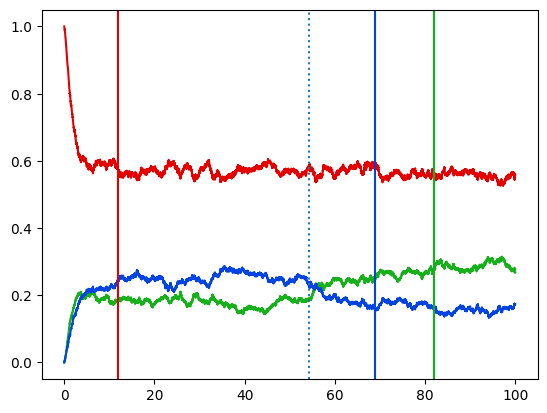

In [30]:
pis, qs = [0.1, 0.1], [9.0, 10.0]
pichain = '_'.join([str(pi) for pi in pis])
qchain = '_'.join([str(q) for q in qs])

# shit happens in sims with these parameters:
# i = 6
# i = 38
# l, lci = 0.6, 1.0
# ci_kwargs = [1, 0.5, 500.0]

# other tests:
i = 77
l, lci = 0.15, 1.0
ci_kwargs = [0, ]
ci_kwargs_chain = '_'.join([str(cikw) for cikw in ci_kwargs])


df = pd.read_csv(f'{resPath}/sim_results_evos_pis_{pichain}_qs_{qchain}_l_{l}_lci_{lci}_cikw_{ci_kwargs_chain}_N_1000_ic_N/time_evo_rea_{i}.csv')

dftss = pd.read_csv(f'{resPath}/tss_from_sim_results_evos_pis_{pichain}_qs_{qchain}_l_{l}_lci_{lci}_cikw_{ci_kwargs_chain}_N_1000_ic_N.csv')

fig, ax = plt.subplots()
ax.plot(df['time'], df['f0'], color='xkcd:red')
ax.plot(df['time'], df['f1'], color='xkcd:green')
ax.plot(df['time'], df['f2'], color='xkcd:blue')

ax.axvline(dftss['tssMax'][i])
ax.axvline(dftss['f0'][i], color='xkcd:red')
ax.axvline(dftss['f1'][i], color='xkcd:green')
ax.axvline(dftss['f2'][i], color='xkcd:blue')
ax.axvline(dftss['tssAvg'][i], ls=':')
print(dftss.iloc[i])


0.9999999999999999 0.27555689000000005
0.0 nan
------
0.5961600000000005 0.20171175
0.4038399999999997 0.4970708020833334
------
0.6617350000000004 0.176090625
0.3382649999999996 0.49416767934782596
------


/Users/david/miniconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Users/david/miniconda3/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


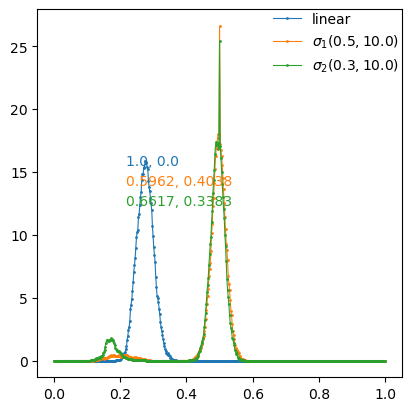

In [29]:
pis, qs, l, lci = [0.1, 0.1], [9.0, 10.0], 0.1, 0.5 # to do cost function data for the lci 0.5 cases
N, ic = 1000, 'N'

# ci_kwargs_list = [[0, ], [1, 0.3, 10.0], [2, 0.3, 10.0]]
ci_kwargs_list = [[0, ], [1, 0.5, 10.0], [2, 0.3, 10.0]]
# ci_kwargs_list = [[0, ], [1, 0.3, 500.0], [2, 0.3, 500.0]]
# ci_kwargs_list = [[0, ], [1, 0.5, 10.0], [2, 0.5, 10.0]]
# ci_kwargs_list = [[0, ], [1, 0.5, 500.0], [2, 0.5, 500.0]]
pichain = '_'.join([str(pi) for pi in pis])
qchain = '_'.join([str(q) for q in qs])

species = []
for ci_kwargs in ci_kwargs_list:
    if len(ci_kwargs) == 1:
        species.append("linear")
    elif len(ci_kwargs) == 4 and int(ci_kwargs[3]) == 1:
        species.append(fr"$\sigma_{ci_kwargs[0]}^{{lin}} ({ci_kwargs[1]}, {ci_kwargs[2]})$")
    else:
        species.append(fr"$\sigma_{ci_kwargs[0]} ({ci_kwargs[1]}, {ci_kwargs[2]})$")

peaksCut = 0.4
peaksAvg = []
peaksProb = []
fig, ax = plt.subplots(1,1,figsize=(4,4), constrained_layout=True)
for i,(ci_kwargs,cilabel) in enumerate(zip(ci_kwargs_list,species)):
    ci_kwargs_chain = '_'.join([str(cikw) for cikw in ci_kwargs])
    ssdata_df = pd.read_csv(f'{resPath}/ss_data_from_sim_results_evos_pis_{pichain}_qs_{qchain}_l_{l}_lci_{lci}_cikw_{ci_kwargs_chain}_N_{N}_ic_{ic}.csv')
    fdata = np.array(ssdata_df['f2'])
    hist, bin_edges = np.histogram(fdata, bins=499, range=(0,1.0), density=True)
    bin_centers = (bin_edges[1:] + bin_edges[:-1])/2
    binWidth = bin_edges[1]-bin_edges[0]
    ln, = ax.plot(bin_centers, hist, marker='.', ms=2, lw=0.8, label=cilabel)
    prob1, ssval1 = sum(hist[bin_centers<0.5]*binWidth), np.average(fdata[fdata<peaksCut])
    prob2, ssval2 = sum(hist[bin_centers>=0.5]*binWidth), np.average(fdata[fdata>=peaksCut])
    fig.text(0.3, 0.6-0.05*i, f'{round(prob1,4)}, {round(prob2,4)}', color=ln.get_color())
    print(prob1, ssval1)
    print(prob2, ssval2)
    print('------')
    peaksAvg.extend([ssval1, ssval2])
    peaksProb.extend([prob1, prob2])
    
fig.legend(frameon=False)


In [83]:
pichain = '_'.join([str(pi) for pi in pis])
qchain = '_'.join([str(q) for q in qs])

sstimes = []
for ci_kwargs in ci_kwargs_list:
    ci_kwargs_chain = '_'.join([str(cikw) for cikw in ci_kwargs])
    fname = f'tss_from_sim_results_evos_pis_{pichain}_qs_{qchain}_l_{l}_lci_{lci}_cikw_{ci_kwargs_chain}_N_{N}_ic_{ic}.csv'
    times_df = pd.read_csv(f'{resPath}/{fname}')
    sstimes.append(np.average(times_df['tss']))

costF_lin = peaksAvg[1]*peaksProb[1]/np.average(sstimes[0])
costF_sig2 = peaksAvg[3]*peaksProb[3]/np.average(sstimes[1])
costF_sig1 = peaksAvg[5]*peaksProb[5]/np.average(sstimes[2])


chi = costF_sig2/costF_lin
print(chi)
chi = costF_sig1/costF_lin
print(chi)

# Cost function for different lambdas

In [7]:
def get_PeaksCutdic_ls(pis, qs, lci):
    # this is for pis 0.1 0.1, qs 9.0 10.0
    if pis[0] == 0.1 and pis[1] == 0.1 and qs[0] == 9.0 and qs[1] == 10.0 and lci == 1.0:
        ls = [0.1, 0.15, 0.2, 0.3, 0.45, 0.6, 0.75, 0.9]
        peaksCut_dic = {
            (0, ): [0.0, 0.0, 0.0, 0.4, 0.4, 0.4, 0.4, 0.4],
            (1, 0.5, 10.0): [0.2, 0.2, 0.35, 0.4, 0.4, 0.4, 0.4, 0.4],
            (2, 0.3, 10.0): [0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4],
            (1, 0.3, 500.0): [0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4],
            (2, 0.3, 500.0): [0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4]
        }
    elif lci == 0.5:
        ls = [0.1, 0.2, 0.3, 0.45, 0.6, 0.75, 0.9]
        peaksCut_dic = {
            (0, ): [0.0, 0.0, 0.35, 0.5, 0.5, 0.5, 0.5],
            (1, 0.5, 10.0): [0.35, 0.4, 0.35, 0.4, 0.4, 0.4, 0.4], # check the ones with a=10
            (2, 0.3, 10.0): [0.34, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4],
            (1, 0.3, 500.0): [0.3, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4],
            (2, 0.3, 500.0): [0.3, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4]
        }
    # pis 0.1 0.1, qs 9.5, 10.0
    if pis[0] == 0.1 and pis[1] == 0.1 and qs[0] == 9.5 and qs[1] == 10.0 and lci == 1.0:
        ls = [0.1, 0.2, 0.3, 0.45, 0.6, 0.75, 0.9]
        peaksCut_dic = {
            (0, ): [0.0, 0.0, 0.3, 0.4, 0.4, 0.4, 0.4, 0.4], # lambda 0.2 still seems to need more equilibration time (current is 400.0)
            (1, 0.5, 10.0): [0.2, 0.2, 0.35, 0.4, 0.4, 0.4, 0.4, 0.4],
            (2, 0.3, 10.0): [0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4],
            (1, 0.3, 500.0): [0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4],
            (2, 0.3, 500.0): [0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4]
        }
    # this is for pis 0.1 0.1, qs 8.0 10.0
    if pis[0] == 0.1 and pis[1] == 0.1 and qs[0] == 8.0 and qs[1] == 10.0 and lci == 1.0:
        ls = [0.1, 0.2, 0.3, 0.45, 0.6, 0.75, 0.9]
        peaksCut_dic = {
            (0, ): [0.0, 0.0, 0.25, 0.5, 0.5, 0.5, 0.5],
            (1, 0.5, 10.0): [0.0, 0.25, 0.4, 0.5, 0.5, 0.5, 0.5],
            (2, 0.3, 10.0): [0.0, 0.25, 0.4, 0.5, 0.5, 0.5, 0.5],
            (1, 0.3, 500.0): [0.25, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
            (2, 0.3, 500.0): [0.25, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
        }
    # this is for pis 0.1 0.1, qs 5.0 10.0
    if pis[0] == 0.1 and pis[1] == 0.1 and qs[0] == 5.0 and qs[1] == 10.0 and lci == 1.0:
        ls = [0.1, 0.2, 0.3, 0.45, 0.6, 0.75, 0.9]
        peaksCut_dic = {
            (0, ): [0.0, 0.0, 0.0, 0.0, 0.5, 0.5, 0.5],
            (1, 0.5, 10.0): [0.0, 0.0, 0.4, 0.5, 0.5, 0.5, 0.5],
            (2, 0.3, 10.0): [0.0, 0.0, 0.4, 0.5, 0.5, 0.5, 0.5],
            (1, 0.3, 500.0): [0.0, 0.0, 0.4, 0.5, 0.5, 0.5, 0.5],
            (2, 0.3, 500.0): [0.0, 0.0, 0.4, 0.5, 0.5, 0.5, 0.5]
        }
    # this is for pis 0.2 0.2, qs 9.0 10.0
    if pis[0] == 0.2 and pis[1] == 0.2 and qs[0] == 9.0 and qs[1] == 10.0 and lci == 1.0:
        ls = [0.1, 0.2, 0.3, 0.45, 0.6, 0.75, 0.9]
        peaksCut_dic = {
            (0, ): [0.0, 0.0, 0.0, 0.5, 0.5, 0.5, 0.5], # probably lambda =0.3 needs more equilibration time...
            # (1, 0.3, 10.0): [0.3, 0.4, 0.5, 0.5, 0.5, 0.5, 0.5],
            (1, 0.5, 10.0): [0.3, 0.4, 0.5, 0.5, 0.5, 0.5, 0.5],
            (2, 0.3, 10.0): [0.3, 0.4, 0.5, 0.5, 0.5, 0.5, 0.5],
            (1, 0.3, 500.0): [0.4, 0.4, 0.4, 0.4, 0.4, 0.5, 0.5],
            (2, 0.3, 500.0): [0.4, 0.4, 0.4, 0.4, 0.4, 0.5, 0.5]
        }
    return peaksCut_dic, ls

In [4]:
pis, qs, lci = [0.1, 0.1], [9.0, 10.0], 0.5
# pis, qs, lci = [0.2, 0.2], [9.0, 10.0], 1.0

def getCostFuncData(pis, qs, lci=1.0):
    N, ic, NreaStatData = 1000, 'N', 10000
    ci_kwargs_list = [(0, ), (1, 0.5, 10.0), (2, 0.3, 10.0), (1, 0.3, 500.0), (2, 0.3, 500.0)]
    costFuncData = {}
    peaksCut_dic, ls = get_PeaksCutdic_ls(pis, qs, lci)
    pichain = '_'.join([str(pi) for pi in pis])
    qchain = '_'.join([str(q) for q in qs])
    winerProbData = pd.read_csv(f'{resPath}/winner_perc_data.csv')
    winerProbData = winerProbData.query('pi1 == @pis[0] & pi2 == @pis[1] & q1 == @qs[0] & q2 == @qs[1] & lci == @lci & ic == @ic & N == @N ') # & Nrea == @NreaStatData
    for ci_kwargs in ci_kwargs_list:
        ci_kwargs_chain = '_'.join([str(cikw) for cikw in ci_kwargs])
        costFuncData[ci_kwargs] = {'f2winVal':[], 'f1loseVal':[], 'probf2winVal':[], 'tss':[], 'CF':[], 'f2winValerr':[], 'f1loseValerr':[], 'probf2winValerr':[], 'tsserr':[], 'CFerr':[]}
        cistr = str(ci_kwargs)
        for l,peaksCut in zip(ls,peaksCut_dic[ci_kwargs]):
            tssDf = pd.read_csv(f'{resPath}/tss_from_sim_results_evos_pis_{pichain}_qs_{qchain}_l_{l}_lci_{lci}_cikw_{ci_kwargs_chain}_N_{N}_ic_{ic}.csv')
            ssDataDf = pd.read_csv(f'{resPath}/ss_data_from_sim_results_evos_pis_{pichain}_qs_{qchain}_l_{l}_lci_{lci}_cikw_{ci_kwargs_chain}_N_{N}_ic_{ic}.csv')
            # time to stationary state:
            tss, tsserr = np.average(tssDf['tssAvg']), np.std(tssDf['tssAvg'])/np.sqrt(len(tssDf['tssAvg']))
            costFuncData[ci_kwargs]['tss'].append(tss), costFuncData[ci_kwargs]['tsserr'].append(tsserr)
            # stationary value when f2 wins:
            f2winVal, f2winValerr = np.average(ssDataDf['f2'][ssDataDf['f2']>=peaksCut]), np.std(ssDataDf['f2'][ssDataDf['f2']>=peaksCut])/np.sqrt(len(ssDataDf['f2']))
            peaksCutf1 = peaksCut if peaksCut > 0.0 else (1-peaksCut)
            f1loseVal, f1loseValerr = np.average(ssDataDf['f1'][ssDataDf['f1']<peaksCutf1]), np.std(ssDataDf['f1'][ssDataDf['f1']<peaksCutf1])/np.sqrt(len(ssDataDf['f1']))
            costFuncData[ci_kwargs]['f2winVal'].append(f2winVal), costFuncData[ci_kwargs]['f2winValerr'].append(f2winValerr)
            costFuncData[ci_kwargs]['f1loseVal'].append(f1loseVal), costFuncData[ci_kwargs]['f1loseValerr'].append(f1loseValerr)
            ### probability to be in the f2 stationary point:
            # hist, bin_edges = np.histogram(ssDataDf['f2'], bins=499, range=(0,1.0), density=True)
            # bin_centers, binWidth = (bin_edges[1:] + bin_edges[:-1])/2, bin_edges[1]-bin_edges[0]
            # probf2win = round(sum(hist[bin_centers>=peaksCut]*binWidth),8)
            # probf2winerr = np.sqrt(probf2win*(1-probf2win)/(len(ssDataDf['f2'])/2000))
            probf2win, NreaStatData = float(winerProbData.query('ci_kwargs == @cistr & l == @l')['f2win'].iloc[0]), float(winerProbData.query('ci_kwargs == @cistr & l == @l')['Nrea'].iloc[0])
            probf2winerr = np.sqrt(probf2win*(1-probf2win)/NreaStatData)
            costFuncData[ci_kwargs]['probf2winVal'].append(probf2win), costFuncData[ci_kwargs]['probf2winValerr'].append(probf2winerr)
            # once having all the data compute the cost function value, and its std by error propagation:
            cf = probf2win*f2winVal/tss
            cferr = (1/tss)*np.sqrt((probf2win*f2winValerr)**2+(f2winVal*probf2winerr)**2+(f2winVal*probf2win*tsserr/tss)**2)
            costFuncData[ci_kwargs]['CF'].append(cf), costFuncData[ci_kwargs]['CFerr'].append(cferr)
    return costFuncData, ls

# NO CROSS INHIBITION LIMIT
# costFuncData_lci0 = {'f2winVal':[], 'probf2winVal':[], 'tss':[], 'CF':[]}
# for l in ls:
#     tssDf = pd.read_csv(f'{resPath}/tss_from_sim_results_evos_pis_{pichain}_qs_{qchain}_l_{l}_lci_0.0_cikw_0_N_{N}_ic_{ic}.csv')
#     ssDataDf = pd.read_csv(f'{resPath}/ss_data_from_sim_results_evos_pis_{pichain}_qs_{qchain}_l_{l}_lci_0.0_cikw_0_N_{N}_ic_{ic}.csv')
#     # time to stationary state:
#     tss = np.average(tssDf['tssAvg'])
#     costFuncData_lci0['tss'].append(tss)
#     # stationary value when f2 wins:
#     f2winVal = np.average(ssDataDf['f2'])
#     costFuncData_lci0['f2winVal'].append(f2winVal)
#     # probability to be in the f2 stationary point:
#     hist, bin_edges = np.histogram(ssDataDf['f2'], bins=499, range=(0,1.0), density=True)
#     bin_centers, binWdith = (bin_edges[1:] + bin_edges[:-1])/2, bin_edges[1]-bin_edges[0]
#     # prob1 = sum(hist[bin_centers<0.5]*binWidth)
#     probf2win = sum(hist*binWidth)
#     costFuncData_lci0['probf2winVal'].append(probf2win)
#     # once having all the data compute the cost function value, and its std by error propagation:
#     cf = probf2win*f2winVal/tss
#     costFuncData_lci0['CF'].append(cf)

NameError: name 'getCostFuncData' is not defined

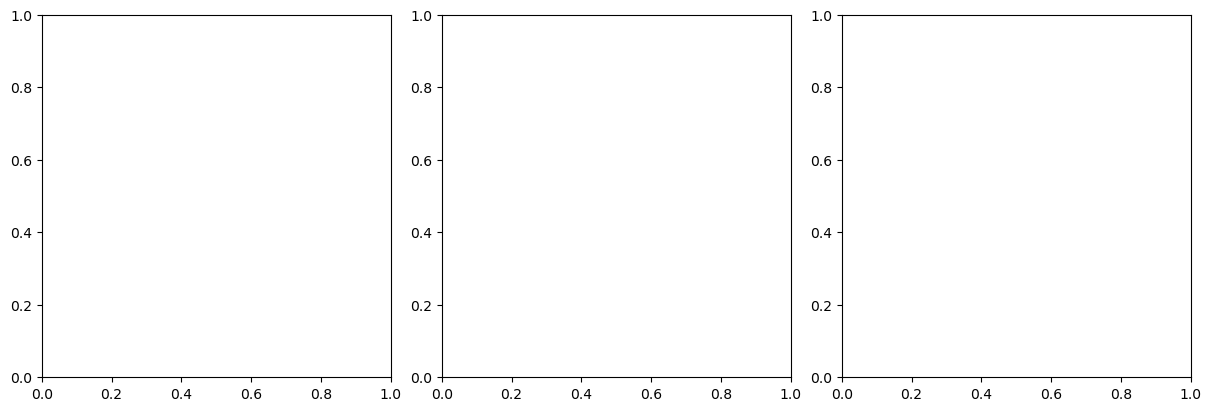

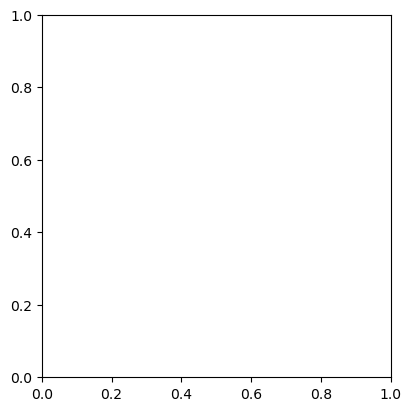

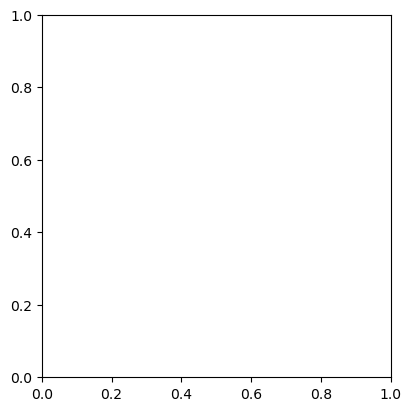

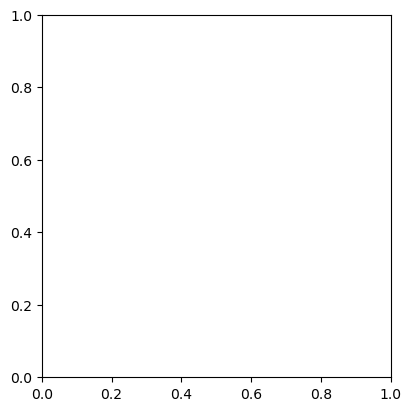

In [3]:
fig, ax = plt.subplots(1,3, figsize=(12,4), constrained_layout=True)
figCF, axCF = plt.subplots(1,1, figsize=(4,4), constrained_layout=True)
figProd, axProd = plt.subplots(1,1, figsize=(4,4), constrained_layout=True)
figQ, axQ = plt.subplots(1,1, figsize=(4,4), constrained_layout=True)
x = 1

ci_kwargs_list = [(0, ), (1, 0.5, 10.0), (2, 0.3, 10.0), (1, 0.3, 500.0), (2, 0.3, 500.0)]
pis, qs, N, ic = [0.1, 0.1], [9.0, 10.0], 1000, 'N'
lci = 0.5
costFuncData, ls = getCostFuncData(pis, qs, lci)

forPaper = False
saveFig = False

# forPaper = True
# saveFig = True

if forPaper:
    latexFont(titlesize=11, ticklabelssize=11, labelsize=13, legendsize=12)
    format = 'pdf'
else:
    format ='png'

ax[0].set(xlabel=r'$\lambda$', ylabel=r'$f_2^*$')
ax[1].set(xlabel=r'$\lambda$', ylabel=r'$P(f_2^*)$')
ax[2].set(xlabel=r'$\lambda$', ylabel=r'$t_{ss}$')
axCF.set(xlabel=r'$\lambda$', ylabel='$\chi$')
# axProd.set(xlabel='$\lambda$', ylabel='$f_2^* \; P(f_2^*)$')
axProd.set(xlabel='$\lambda$', ylabel='$\psi$')
if x == 1:
    axQ.set(xlabel='$\lambda$', ylabel='$f_2 - f_1$')
else:
    axQ.set(xlabel='$\lambda$', ylabel=fr'$f_2 - {x} f_1$')

species = []
for ci_kwargs in ci_kwargs_list:
    if len(ci_kwargs) == 1:
        species.append("linear")
    elif len(ci_kwargs) == 4 and int(ci_kwargs[3]) == 1:
        species.append(fr"$\sigma_{ci_kwargs[0]}^{{lin}} ({ci_kwargs[1]}, {ci_kwargs[2]})$")
    else:
        species.append(fr"$\sigma_{ci_kwargs[0]} ({ci_kwargs[1]}, {ci_kwargs[2]})$")


ebars = True
# jitterer = np.linspace(-0.015,0.015, len(ci_kwargs_list))
jitterer = np.linspace(-0.0,0.0, len(ci_kwargs_list))
# ci_kwargs_list = [(0, ), (1, 0.3, 10.0), (2, 0.3, 10.0), (1, 0.3, 500.0), (2, 0.3, 500.0)]
color_seq = ['k', 'xkcd:sky blue', 'xkcd:light red', 'xkcd:bright blue', 'xkcd:deep red']
marker_seq = ['o', 's', 'd', 'v', '^']
if ebars:
    for ci_kwargs, cilabel, c, m, jit in zip(ci_kwargs_list, species, color_seq, marker_seq, jitterer):
        # ebars are very small for f2winVal; for them to not be seen in the legend let's simply plot
        ax[0].errorbar(ls+jit, costFuncData[tuple(ci_kwargs)]['f2winVal'], costFuncData[tuple(ci_kwargs)]['f2winValerr'], lw=0.8, marker=m, color=c, mfc='w', label=cilabel, capsize=2.0)
        # ax[0].plot(ls+jit, costFuncData[tuple(ci_kwargs)]['f2winVal'], lw=0.8, marker=m, color=c, mfc='w', label=cilabel)
        ax[1].errorbar(ls+jit, costFuncData[tuple(ci_kwargs)]['probf2winVal'], costFuncData[tuple(ci_kwargs)]['probf2winValerr'], lw=0.8, marker=m, color=c, mfc='w', capsize=2.0)
        ax[2].errorbar(ls+jit, costFuncData[tuple(ci_kwargs)]['tss'], costFuncData[tuple(ci_kwargs)]['tsserr'], lw=0.8, marker=m, color=c, mfc='w', capsize=2.0)
        # product of f2* and prob(f2*)
        # prod = np.array(costFuncData[tuple(ci_kwargs)]['f2winVal'])*np.array(costFuncData[tuple(ci_kwargs)]['probf2winVal'])
        # axProd.plot(ls+jit, prod, lw=0.8, marker='o', color=c, mfc='w', label=cilabel) # only the product of f2*probf2
        axProd.errorbar(ls+jit, costFuncData[tuple(ci_kwargs)]['CF'], costFuncData[tuple(ci_kwargs)]['CFerr'], lw=0.8, marker=m, color=c, mfc='w', label=cilabel, capsize=2.0) # the psi function
        axQ.plot(ls, np.array(costFuncData[tuple(ci_kwargs)]['f2winVal'])-np.array(costFuncData[tuple(ci_kwargs)]['f1loseVal']), lw=0.8, marker=m, color=c, mfc='w', label=cilabel)
else:
    for ci_kwargs, cilabel, c, m in zip(ci_kwargs_list, species, color_seq, marker_seq):
        ax[0].plot(ls, costFuncData[tuple(ci_kwargs)]['f2winVal'], lw=0.8, marker=m, color=c, mfc='w', label=cilabel)
        ax[1].plot(ls, costFuncData[tuple(ci_kwargs)]['probf2winVal'], lw=0.8, marker=m, color=c, mfc='w')
        ax[2].plot(ls, costFuncData[tuple(ci_kwargs)]['tss'], lw=0.8, marker=m, color=c, mfc='w')
        axQ.plot(ls, np.array(costFuncData[tuple(ci_kwargs)]['f2winVal'])-np.array(costFuncData[tuple(ci_kwargs)]['f1loseVal']), lw=0.8, marker=m, color=c, mfc='w', label=cilabel)
ax[0].legend(frameon=False)
axProd.legend(frameon=False, fontsize=9, ncol=2)

# add no cross inhibition data...
# ax[0].plot(ls, costFuncData_lci0['f2winVal'], lw=0.9, marker='o', mfc='w', color='k', alpha=0.8, label='No CI')
# ax[1].plot(ls, costFuncData_lci0['probf2winVal'], lw=0.9, marker='o', mfc='w', color='k', alpha=0.8)
# ax[2].plot(ls, costFuncData_lci0['tss'], lw=0.9, marker='o', mfc='w', color='k', alpha=0.8)


# lets call the cost function with the greek letter psi, and the ratio with chi
# jitterer = np.linspace(-0.01,0.01, len(ci_kwargs_list[1:]))
jitterer = np.linspace(-0.0,0.0, len(ci_kwargs_list[1:]))
psiLin, psiLinerr = np.array(costFuncData[(0, )]['CF']), np.array(costFuncData[(0, )]['CFerr'])
for i,(ci_kwargs,cilabel,c,m,jit) in enumerate(zip(ci_kwargs_list[1:],species[1:],color_seq[1:],marker_seq[1:], jitterer)):
    psiCI, psiCIerr = np.array(costFuncData[tuple(ci_kwargs)]['CF']), np.array(costFuncData[tuple(ci_kwargs)]['CFerr'])
    chi = psiCI/psiLin
    chierr = (1/psiLin)*np.sqrt(psiCIerr**2 + (chi*psiLinerr)**2)
    if ebars:
        axCF.errorbar(ls+jit, chi, chierr, marker=m, mfc='w', color=c, capsize=2.0, lw=0.8, label=cilabel) # to use the standard color sequence: color=f'C{i+1}',
    else:
        axCF.plot(ls, chi, marker=m, mfc='w', color=c, lw=0.8)

axCF.axhline(1.0, 0, 1, ls=':', lw=0.8, color='xkcd:grey')
axCF.legend(frameon=False)

if forPaper:
    ax[0].text(0.06,0.91, r'$\textbf{A}$', fontsize=17, transform=ax[0].transAxes)
    ax[1].text(0.89,0.91, r'$\textbf{B}$', fontsize=17, transform=ax[1].transAxes)
    ax[2].text(0.06,0.91, r'$\textbf{C}$', fontsize=17, transform=ax[2].transAxes)

# ci_kwargs_chain = '_'.join([str(cikw) for cikw in ci_kwargs])
pichain = '_'.join([str(pi) for pi in pis])
qchain = '_'.join([str(q) for q in qs])
altLabel = '_ALT' if ci_kwargs_list[1][1] != ci_kwargs_list[2][1] else ''

if saveFig:
    fig.savefig(f'cost_func_data_pis_{pichain}_qs_{qchain}_lci_{lci}_N_{N}_ic_{ic}_sig12_dif_a_x0_{ci_kwargs_list[1][1]}{altLabel}.{format}')
    figCF.savefig(f'chi_pis_{pichain}_qs_{qchain}_lci_{lci}_N_{N}_ic_{ic}_sig12_dif_a_x0_{ci_kwargs_list[2][1]}{altLabel}.{format}')
    figProd.savefig(f'psi_pis_{pichain}_qs_{qchain}_lci_{lci}_N_{N}_ic_{ic}_sig12_dif_a_x0_{ci_kwargs_list[1][1]}{altLabel}.png')

### cost function multiplot varying q1

In [16]:
q1s = [5.0, 8.0, 9.0, 9.5]
costFuncs_q1s = []
ls_q1s = []
for q1 in q1s:
    costFuncData, ls = getCostFuncData([0.1, 0.1], [q1, 10.0])
    costFuncs_q1s.append(costFuncData)
    ls_q1s.append(ls)

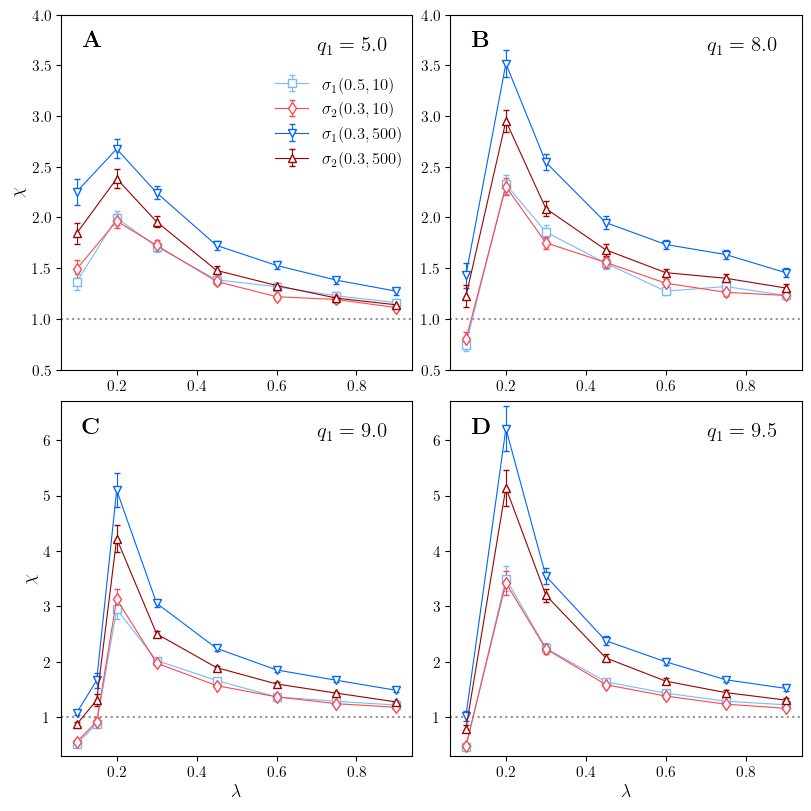

In [17]:
fig, ax = plt.subplots(2,2, figsize=(8,8), constrained_layout=True)
latexFont(titlesize=11, ticklabelssize=11, labelsize=13, legendsize=12)

ax[0,0].set_ylabel('$\chi$')
ax[1,0].set_ylabel('$\chi$')
ax[1,0].set_xlabel('$\lambda$')
ax[1,1].set_xlabel('$\lambda$')

ci_kwargs_list = [(0, ), (1, 0.5, 10.0), (2, 0.3, 10.0), (1, 0.3, 500.0), (2, 0.3, 500.0)]
color_seq = ['k', 'xkcd:sky blue', 'xkcd:light red', 'xkcd:bright blue', 'xkcd:deep red']
# marker_seq = ['o', 'H', 'd', 'p', '^']
marker_seq = ['o', 's', 'd', 'v', '^']

for i,q1 in enumerate(q1s):
    # costFuncData, ls = getCostFuncData([0.1, 0.1], [q1, 10.0])
    costFuncData, ls = costFuncs_q1s[i], ls_q1s[i]
    psiLin, psiLinerr = np.array(costFuncData[(0, )]['CF']), np.array(costFuncData[(0, )]['CFerr'])
    iax, jax = int(i/2), i%2
    for j,(ci_kwargs,c,m) in enumerate(zip(ci_kwargs_list[1:],color_seq[1:],marker_seq[1:])):
        cilabel=fr"$\sigma_{ci_kwargs[0]} ({ci_kwargs[1]}, {int(ci_kwargs[2])})$" if (iax == 0 and jax == 0) else '_nolabel_'
        psiCI, psiCIerr = np.array(costFuncData[tuple(ci_kwargs)]['CF']), np.array(costFuncData[tuple(ci_kwargs)]['CFerr'])
        chi = psiCI/psiLin
        chierr = (1/psiLin)*np.sqrt(psiCIerr**2 + (chi*psiLinerr)**2)
        ax[iax, jax].errorbar(ls, chi, chierr, marker=m, mfc='w', color=c, capsize=2.0, lw=0.8, label=cilabel)
    ax[int(i/2), i%2].axhline(1.0, 0, 1, ls=':', color='xkcd:gray')
    # ax[int(i/2), i%2].set_ylim(0.4,6.6)
    ax[int(i/2), i%2].text(0.73, 0.9, rf'$q_1 = {q1}$', transform=ax[int(i/2), i%2].transAxes)

ax[0,0].legend(frameon=False, loc=(0.59, 0.55))
# ax[0,0].legend(frameon=False, ncol=2, loc=(0.15, 0.72))
ax[0,0].set_ylim(0.5, 4.0)
ax[0,1].set_ylim(0.5, 4.0)
ax[1,0].set_ylim(0.3, 6.7)
ax[1,1].set_ylim(0.3, 6.7)

ax[0,0].text(0.06,0.91, r'$\textbf{A}$', fontsize=17, transform=ax[0,0].transAxes)
ax[0,1].text(0.06,0.91, r'$\textbf{B}$', fontsize=17, transform=ax[0,1].transAxes)
ax[1,0].text(0.06,0.91, r'$\textbf{C}$', fontsize=17, transform=ax[1,0].transAxes)
ax[1,1].text(0.06,0.91, r'$\textbf{D}$', fontsize=17, transform=ax[1,1].transAxes)

fig.savefig('chi_multiplot_q1_q2_10.0_pis_0.1_0.1_lci_1.0.pdf')

# cost function for different noises

In [19]:
qs, l, lci = [9.0, 10.0], 0.6, 1.0
N, ic, NreaStatData = 1000, 'N', 10000

ci_kwargs_list = [(0, ), (1, 0.5, 10.0), (2, 0.3, 10.0), (1, 0.3, 500.0), (2, 0.3, 500.0)]
pis = [0.1, 0.15, 0.2, 0.25, 0.3, 0.4]

costFuncData = {}
peaksCut = 0.4

qchain = '_'.join([str(q) for q in qs])

winerProbData = pd.read_csv(f'{resPath}/winner_perc_data.csv')
winerProbData = winerProbData.query('q1 == @qs[0] & q2 == @qs[1] & l == @l & lci == @lci & ic == @ic & N == @N ') # & Nrea == @NreaStatData
for ci_kwargs in ci_kwargs_list:
    ci_kwargs_chain = '_'.join([str(cikw) for cikw in ci_kwargs])
    costFuncData[ci_kwargs] = {'f2winVal':[], 'f1loseVal':[], 'probf2winVal':[], 'tss':[], 'CF':[], 'f2winValerr':[], 'f1loseValerr':[], 'probf2winValerr':[], 'tsserr':[], 'CFerr':[]}
    cistr = str(ci_kwargs)
    for pi in pis:
        pichain = f'{pi}_{pi}'
        tssDf = pd.read_csv(f'{resPath}/tss_from_sim_results_evos_pis_{pichain}_qs_{qchain}_l_{l}_lci_{lci}_cikw_{ci_kwargs_chain}_N_{N}_ic_{ic}.csv')
        ssDataDf = pd.read_csv(f'{resPath}/ss_data_from_sim_results_evos_pis_{pichain}_qs_{qchain}_l_{l}_lci_{lci}_cikw_{ci_kwargs_chain}_N_{N}_ic_{ic}.csv')
        # time to stationary state:
        tss, tsserr = np.average(tssDf['tssAvg']), np.std(tssDf['tssAvg'])/np.sqrt(len(tssDf['tssAvg']))
        costFuncData[ci_kwargs]['tss'].append(tss), costFuncData[ci_kwargs]['tsserr'].append(tsserr)
        # stationary value when f2 wins:
        peaksCutf1 = peaksCut if peaksCut > 0.0 else (1-peaksCut)
        f2winVal, f2winValerr = np.average(ssDataDf['f2'][ssDataDf['f2']>=peaksCut]), np.std(ssDataDf['f2'][ssDataDf['f2']>=peaksCut])/np.sqrt(len(ssDataDf['f2']))
        f1loseVal, f1loseValerr = np.average(ssDataDf['f1'][ssDataDf['f1']<peaksCutf1]), np.std(ssDataDf['f1'][ssDataDf['f1']<peaksCutf1])/np.sqrt(len(ssDataDf['f1']))
        costFuncData[ci_kwargs]['f2winVal'].append(f2winVal), costFuncData[ci_kwargs]['f2winValerr'].append(f2winValerr)
        costFuncData[ci_kwargs]['f1loseVal'].append(f1loseVal), costFuncData[ci_kwargs]['f1loseValerr'].append(f1loseValerr)
        ### probability to be in the f2 stationary point:
        # hist, bin_edges = np.histogram(ssDataDf['f2'], bins=499, range=(0,1.0), density=True)
        # bin_centers, binWidth = (bin_edges[1:] + bin_edges[:-1])/2, bin_edges[1]-bin_edges[0]
        # probf2win = round(sum(hist[bin_centers>=peaksCut]*binWidth),8)
        # probf2winerr = np.sqrt(probf2win*(1-probf2win)/(len(ssDataDf['f2'])/2000))
        probf2win, NreaStatData = float(winerProbData.query('ci_kwargs == @cistr & pi1 == @pi & pi2 == @pi')['f2win'].iloc[0]), float(winerProbData.query('ci_kwargs == @cistr & pi1 == @pi & pi2 == @pi')['Nrea'].iloc[0])
        probf2winerr = np.sqrt(probf2win*(1-probf2win)/NreaStatData)
        costFuncData[ci_kwargs]['probf2winVal'].append(probf2win), costFuncData[ci_kwargs]['probf2winValerr'].append(probf2winerr)
        # once having all the data compute the cost function value, and its std by error propagation:
        cf = probf2win*f2winVal/tss
        cferr = (1/tss)*np.sqrt((probf2win*f2winValerr)**2+(f2winVal*probf2winerr)**2+(f2winVal*probf2win*tsserr/tss)**2)
        costFuncData[ci_kwargs]['CF'].append(cf), costFuncData[ci_kwargs]['CFerr'].append(cferr)

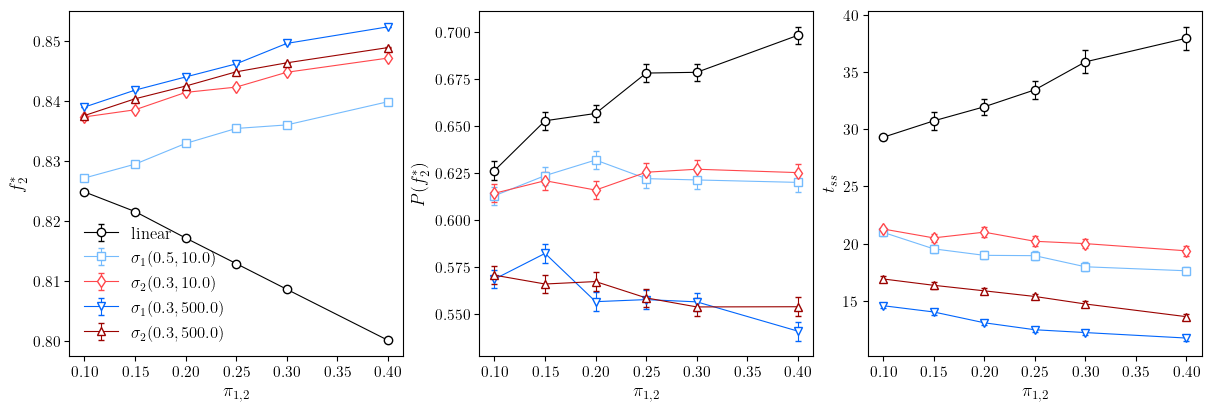

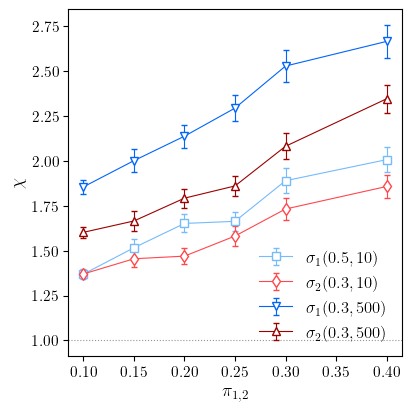

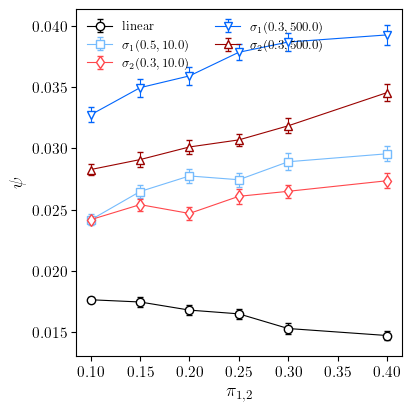

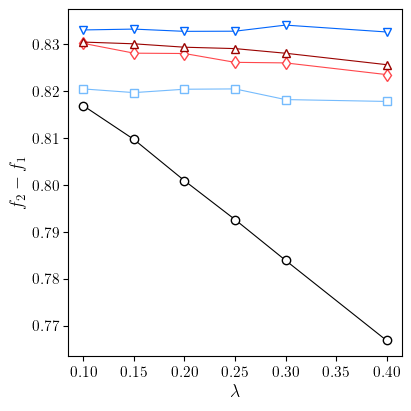

In [23]:
fig, ax = plt.subplots(1,3, figsize=(12,4), constrained_layout=True)
figCF, axCF = plt.subplots(1,1, figsize=(4,4), constrained_layout=True)
figProd, axProd = plt.subplots(1,1, figsize=(4,4), constrained_layout=True)
figQ, axQ = plt.subplots(1,1, figsize=(4,4), constrained_layout=True)
x = 1

ax[0].set(xlabel='$\pi_{1,2}$', ylabel='$f_2^*$')
ax[1].set(xlabel='$\pi_{1,2}$', ylabel='$P(f_2^*)$')
ax[2].set(xlabel='$\pi_{1,2}$', ylabel=r'$t_{ss}$')
axCF.set(xlabel='$\pi_{1,2}$', ylabel='$\chi$')
# axProd.set(xlabel='$\lambda$', ylabel='$f_2^* \; P(f_2^*)$')
axProd.set(xlabel='$\pi_{1,2}$', ylabel='$\psi$')
if x == 1:
    axQ.set(xlabel='$\lambda$', ylabel='$f_2 - f_1$')
else:
    axQ.set(xlabel='$\lambda$', ylabel=fr'$f_2 - {x} f_1$')

species = []
for ci_kwargs in ci_kwargs_list:
    if len(ci_kwargs) == 1:
        species.append("linear")
    elif len(ci_kwargs) == 4 and int(ci_kwargs[3]) == 1:
        species.append(fr"$\sigma_{ci_kwargs[0]}^{{lin}} ({ci_kwargs[1]}, {ci_kwargs[2]})$")
    else:
        species.append(fr"$\sigma_{ci_kwargs[0]} ({ci_kwargs[1]}, {ci_kwargs[2]})$")


ebars = True
# jitterer = np.linspace(-0.015,0.015, len(ci_kwargs_list))
jitterer = np.linspace(-0.0,0.0, len(ci_kwargs_list))
marker_seq = ['o', 's', 'd', 'v', '^']
# ci_kwargs_list = [(0, ), (1, 0.3, 10.0), (2, 0.3, 10.0), (1, 0.3, 500.0), (2, 0.3, 500.0)]
color_seq = ['k', 'xkcd:sky blue', 'xkcd:light red', 'xkcd:bright blue', 'xkcd:deep red']
if ebars:
    for ci_kwargs, cilabel, c, marker, jit in zip(ci_kwargs_list, species, color_seq, marker_seq, jitterer):
        ax[0].errorbar(pis+jit, costFuncData[tuple(ci_kwargs)]['f2winVal'], costFuncData[tuple(ci_kwargs)]['f2winValerr'], lw=0.8, marker=marker, color=c, mfc='w', label=cilabel, capsize=2.0)
        ax[1].errorbar(pis+jit, costFuncData[tuple(ci_kwargs)]['probf2winVal'], costFuncData[tuple(ci_kwargs)]['probf2winValerr'], lw=0.8, marker=marker, color=c, mfc='w', capsize=2.0)
        ax[2].errorbar(pis+jit, costFuncData[tuple(ci_kwargs)]['tss'], costFuncData[tuple(ci_kwargs)]['tsserr'], lw=0.8, marker=marker, color=c, mfc='w', capsize=2.0)
        # product of f2* and prob(f2*)
        # prod = np.array(costFuncData[tuple(ci_kwargs)]['f2winVal'])*np.array(costFuncData[tuple(ci_kwargs)]['probf2winVal'])
        # axProd.plot(ls+jit, prod, lw=0.8, marker='o', color=c, mfc='w', label=cilabel) # only the product of f2*probf2
        axProd.errorbar(pis+jit, costFuncData[tuple(ci_kwargs)]['CF'], costFuncData[tuple(ci_kwargs)]['CFerr'], lw=0.8, marker=marker, color=c, mfc='w', label=cilabel, capsize=2.0) # the psi function
        axQ.plot(pis, np.array(costFuncData[tuple(ci_kwargs)]['f2winVal'])-np.array(costFuncData[tuple(ci_kwargs)]['f1loseVal']), lw=0.8, marker=marker, color=c, mfc='w', label=cilabel)
else:
    for ci_kwargs, cilabel, c, marker in zip(ci_kwargs_list, species, color_seq, marker_seq):
        ax[0].plot(pis, costFuncData[tuple(ci_kwargs)]['f2winVal'], lw=0.8, marker=marker, color=c, mfc='w', label=cilabel)
        ax[1].plot(pis, costFuncData[tuple(ci_kwargs)]['probf2winVal'], lw=0.8, marker=marker, color=c, mfc='w')
        ax[2].plot(pis, costFuncData[tuple(ci_kwargs)]['tss'], lw=0.8, marker=marker, color=c, mfc='w')
        axQ.plot(pis, np.array(costFuncData[tuple(ci_kwargs)]['f2winVal'])-np.array(costFuncData[tuple(ci_kwargs)]['f1loseVal']), lw=0.8, marker=marker, color=c, mfc='w', label=cilabel)
ax[0].legend(frameon=False)
axProd.legend(frameon=False, fontsize=9, ncol=2)


# lets call the cost function with the greek letter psi, and the ratio with chi
# jitterer = np.linspace(-0.01,0.01, len(ci_kwargs_list[1:]))
jitterer = np.linspace(-0.0,0.0, len(ci_kwargs_list[1:]))
psiLin, psiLinerr = np.array(costFuncData[(0, )]['CF']), np.array(costFuncData[(0, )]['CFerr'])
for i,(ci_kwargs,cilabel,c,marker,jit) in enumerate(zip(ci_kwargs_list[1:],species[1:],color_seq[1:], marker_seq[1:], jitterer)):
    cilabelmod=fr"$\sigma_{ci_kwargs[0]} ({ci_kwargs[1]}, {int(ci_kwargs[2])})$"
    psiCI, psiCIerr = np.array(costFuncData[tuple(ci_kwargs)]['CF']), np.array(costFuncData[tuple(ci_kwargs)]['CFerr'])
    chi = psiCI/psiLin
    chierr = (1/psiLin)*np.sqrt(psiCIerr**2 + (chi*psiLinerr)**2)
    if ebars:
        axCF.errorbar(pis+jit, chi, chierr, marker=marker, mfc='w', color=c, capsize=2.0, lw=0.8, label=cilabelmod) # to use the standard color sequence: color=f'C{i+1}',
    else:
        axCF.plot(pis, chi, marker=marker, mfc='w', color=c, lw=0.8)

axCF.axhline(1.0, 0, 1, ls=':', lw=0.8, color='xkcd:grey')
axCF.legend(frameon=False)

# fig.savefig(f'cost_func_data_qs_{qchain}_l_{l}_lci_{lci}_N_{N}_ic_{ic}_sig12_dif_a_x0_{ci_kwargs_list[1][1]}.png')
figCF.savefig(f'chi_qs_{qchain}_l_{l}_lci_{lci}_N_{N}_ic_{ic}_sig12_dif_a_x0_{ci_kwargs_list[1][1]}.png')
# figProd.savefig(f'psi_qs_{qchain}_l_{l}_lci_{lci}_N_{N}_ic_{ic}_sig12_dif_a_x0_{ci_kwargs_list[1][1]}.png')

figCF.savefig(f'chi_qs_{qchain}_l_{l}_lci_{lci}_N_{N}_ic_{ic}_sig12_dif_a_x0_{ci_kwargs_list[1][1]}.pdf')

## First passage times over the avg stationary value across many realizations...

In [ ]:
pis, qs, lci = [0.1, 0.1], [9.0, 10.0], 1.0
N, ic = 1000, 'N'

pichain = '_'.join([str(pi) for pi in pis])
qchain = '_'.join([str(q) for q in qs])

ls = [0.1, 0.2, 0.3, 0.45, 0.6, 0.9]
# ci_kwargs_list = [(0, ), (1, 0.3, 10.0), (2, 0.3, 10.0), (1, 0.3, 500.0), (2, 0.3, 500.0)]
ci_kwargs_list = [(0, ), ]

peaksCut_dic = {
    (0, ): [0.0, 0.0, 0.4, 0.4, 0.4, 0.4],
    (1, 0.3, 10.0): [0.2, 0.35, 0.4, 0.4, 0.4, 0.4],
    (2, 0.3, 10.0): [0.4, 0.4, 0.4, 0.4, 0.4, 0.4],
    (1, 0.3, 500.0): [0.4, 0.4, 0.4, 0.4, 0.4, 0.4],
    (2, 0.3, 500.0): [0.4, 0.4, 0.4, 0.4, 0.4, 0.4]
}

fptimes_dic = {}
for ci_kwargs in ci_kwargs_list:
    ci_kwargs_chain = '_'.join([str(cikw) for cikw in ci_kwargs])
    fptimes_dic[tuple(ci_kwargs)] = {}
    for l,peaksCut in zip(ls,peaksCut_dic[ci_kwargs]):
        ### tssDf = pd.read_csv(f'{resPath}/tss_from_sim_results_evos_pis_{pichain}_qs_{qchain}_l_{l}_lci_{lci}_cikw_{ci_kwargs_chain}_N_{N}_ic_{ic}.csv')
        # stationary value when f2 wins:
        ssDataDf = pd.read_csv(f'{resPath}/ss_data_from_sim_results_evos_pis_{pichain}_qs_{qchain}_l_{l}_lci_{lci}_cikw_{ci_kwargs_chain}_N_{N}_ic_{ic}.csv')
        f2winVal, f2winValstd = np.average(ssDataDf['f2'][ssDataDf['f2']>=peaksCut]), np.std(ssDataDf['f2'][ssDataDf['f2']>=peaksCut])
        f2loseVal, f2loseValstd = np.average(ssDataDf['f2'][ssDataDf['f2']<peaksCut]), np.std(ssDataDf['f2'][ssDataDf['f2']<peaksCut])
        # get first passage time from time evolutions...
        evoName = f'sim_results_evos_pis_{pichain}_qs_{qchain}_l_{l}_lci_{lci}_cikw_{ci_kwargs_chain}_N_{N}_ic_{ic}'
        evoFiles = glob.glob(f'{resPath}/{evoName}/*')
        fptimes = []
        for i in range(len(evoFiles)):
            f = f'{resPath}/{evoName}/time_evo_rea_{i}.csv'
            tevo = pd.read_csv(f)
            tevo['f2winValdif'] = abs(tevo['f2'] - f2winVal)
            tevo['f2loseValdif'] = abs(tevo['f2'] - f2loseVal)
            thresh = 0.8*f2winValstd
            times = list(tevo.query('f2winValdif < @thresh & time > 2.0')['time'])
            if len(times) == 0:
                thresh = 0.8*f2loseValstd
                times = list(tevo.query('f2loseValdif < @f2loseValstd & time > 2.0')['time'])
            if len(times) > 0:
                fptimes.append(times[0])
            else:
                print(f'could not find fpt for rea {i} with ci_kwargs = {ci_kwargs} and l = {l}')
        fptimes_dic[tuple(ci_kwargs)][l] = fptimes


fptAvg_l, fptStd_l = [], []
for l,fptimes in fptimes_dic[(0, )].items():
    fptavg, fptstd = np.average(fptimes), np.std(fptimes)
    fptAvg_l.append(fptavg), fptStd_l.append(fptstd)
print(fptAvg_l)
print(fptStd_l)

# Estimate winner probabilities from the autoStop gillespie program

## comparison between data computed from "cost func data" and dedicated simulations

<ErrorbarContainer object of 3 artists>

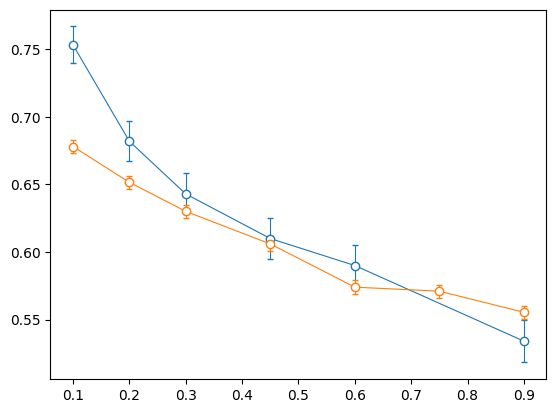

In [35]:
pis, qs, lci = [0.2, 0.2], [9.0, 10.0], 1.0
N, ic = 1000, 'N'

ls = [0.1, 0.2, 0.3, 0.45, 0.6, 0.75, 0.9]
ls = [0.1, 0.2, 0.3, 0.45, 0.6, 0.9]
ci_kwargs = [1, 0.3, 10.0]

fig, ax = plt.subplots()

# cost function data
ax.errorbar(ls, costFuncData[tuple(ci_kwargs)]['probf2winVal'], costFuncData[tuple(ci_kwargs)]['probf2winValerr'], lw=0.8, marker='o', mfc='w', capsize=2.0)

dfwinf = pd.read_csv(f'{resPath}/winner_perc_data.csv')
cistr = str(tuple(ci_kwargs))
dfwinf = dfwinf.query('ci_kwargs == @cistr & pi1 == @pis[0] & pi2 == @pis[1]').copy()
dfwinf['f2winerr'] = np.sqrt(dfwinf['f2win']*(1-dfwinf['f2win'])/dfwinf['Nrea'])
ax.errorbar(dfwinf['l'], dfwinf['f2win'], dfwinf['f2winerr'], lw=0.8, marker='o', mfc='w', capsize=2.0)

# 3 sites

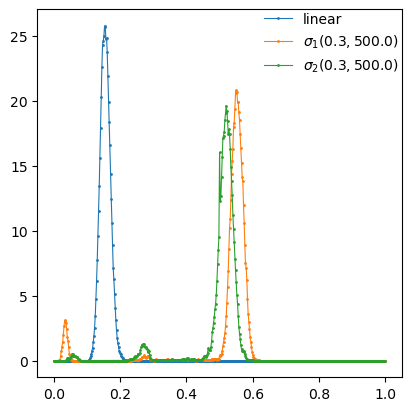

In [9]:
pis, qs, l, lci = [0.1, 0.1, 0.1], [8.0, 9.0, 10.0], 0.1, 1.0
N, ic = 1000, 'N'

# ci_kwargs_list = [[0, ], [1, 0.5, 10.0], [2, 0.3, 10.0]]
ci_kwargs_list = [[0, ], [1, 0.3, 500.0], [2, 0.3, 500.0]]

pichain = '_'.join([str(pi) for pi in pis])
qchain = '_'.join([str(q) for q in qs])

species = []
for ci_kwargs in ci_kwargs_list:
    if len(ci_kwargs) == 1:
        species.append("linear")
    elif len(ci_kwargs) == 4 and int(ci_kwargs[3]) == 1:
        species.append(fr"$\sigma_{ci_kwargs[0]}^{{lin}} ({ci_kwargs[1]}, {ci_kwargs[2]})$")
    else:
        species.append(fr"$\sigma_{ci_kwargs[0]} ({ci_kwargs[1]}, {ci_kwargs[2]})$")

peaksCut = 0.4
peaksAvg = []
peaksProb = []
fig, ax = plt.subplots(1,1,figsize=(4,4), constrained_layout=True)
for i,(ci_kwargs,cilabel) in enumerate(zip(ci_kwargs_list,species)):
    ci_kwargs_chain = '_'.join([str(cikw) for cikw in ci_kwargs])
    ssdata_df = pd.read_csv(f'{resPath}/ss_data_from_sim_results_evos_pis_{pichain}_qs_{qchain}_l_{l}_lci_{lci}_cikw_{ci_kwargs_chain}_N_{N}_ic_{ic}.csv')
    fdata = np.array(ssdata_df['f3'])
    hist, bin_edges = np.histogram(fdata, bins=499, range=(0,1.0), density=True)
    bin_centers = (bin_edges[1:] + bin_edges[:-1])/2
    binWidth = bin_edges[1]-bin_edges[0]
    ln, = ax.plot(bin_centers, hist, marker='.', ms=2, lw=0.8, label=cilabel)
    # prob1, ssval1 = sum(hist[bin_centers<0.5]*binWidth), np.average(fdata[fdata<peaksCut])
    # prob2, ssval2 = sum(hist[bin_centers>=0.5]*binWidth), np.average(fdata[fdata>=peaksCut])
    # fig.text(0.3, 0.6-0.05*i, f'{round(prob1,4)}, {round(prob2,4)}', color=ln.get_color())
    # print(prob1, ssval1)
    # print(prob2, ssval2)
    # print('------')
    # peaksAvg.extend([ssval1, ssval2])
    # peaksProb.extend([prob1, prob2])
    
fig.legend(frameon=False)

In [6]:
# there may be 3 peaks; this is intented for selecting the highest one!
def get_PeaksCutdic_ls_ksites(pis, qs, lci=1.0):
    # this is for pis 0.1 0.1 0.1, qs 8.0 9.0 10.0
    if pis[0] == 0.1 and pis[1] == 0.1 and pis[2] == 0.1 and qs[0] == 8.0 and qs[1] == 9.0 and qs[2] == 10.0 and lci == 1.0:
        ls = [0.1, 0.2, 0.3, 0.45, 0.6, 0.75, 0.9]
        peaksCut_dic = {
            (0, ): [0.0, 0.0, 0.0, 0.4, 0.4, 0.4, 0.4], # to do
            (1, 0.5, 10.0): [0.2, 0.2, 0.35, 0.4, 0.4, 0.4, 0.4], # to do
            (2, 0.3, 10.0): [0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4], # to do
            (1, 0.3, 500.0): [0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4],
            (2, 0.3, 500.0): [0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4]
        }
    return peaksCut_dic, ls

In [17]:
def getCostFuncData_ksites(pis, qs, ci_kwargs_list, lci=1.0, probsFromHist=False):
    N, ic, NreaStatData = 1000, 'N', 10000
    # ci_kwargs_list = [(0, ), (1, 0.5, 10.0), (2, 0.3, 10.0), (1, 0.3, 500.0), (2, 0.3, 500.0)]
    costFuncData = {}
    peaksCut_dic, ls = get_PeaksCutdic_ls_ksites(pis, qs, lci)
    k = int(len(pis))
    pichain = '_'.join([str(pi) for pi in pis])
    qchain = '_'.join([str(q) for q in qs])
    sitesSufix = f'_{k}_sites' if k > 2 else ''
    winerProbData = pd.read_csv(f'{resPath}/winner_perc_data{sitesSufix}.csv')
    query_pis = ' & '.join([f'pi{i+1} == @pis[{i}]' for i in range(k)])
    query_qs = ' & '.join(f'q{i+1} == @qs[{i}]' for i in range(k))
    winerProbData = winerProbData.query(f'{query_pis} & {query_qs} & lci == @lci & ic == @ic & N == @N ')
    # winerProbData = winerProbData.query('pi1 == @pis[0] & pi2 == @pis[1] & q1 == @qs[0] & q2 == @qs[1] & lci == @lci & ic == @ic & N == @N ') # adapt
    for ci_kwargs in ci_kwargs_list:
        ci_kwargs_chain = '_'.join([str(cikw) for cikw in ci_kwargs])
        costFuncData[ci_kwargs] = {'fkwinVal':[], 'probfkwinVal':[], 'tss':[], 'CF':[], 'fkwinValerr':[], 'probfkwinValerr':[], 'tsserr':[], 'CFerr':[]}
        cistr = str(ci_kwargs)
        for l,peaksCut in zip(ls,peaksCut_dic[ci_kwargs]):
            tssDf = pd.read_csv(f'{resPath}/tss_from_sim_results_evos_pis_{pichain}_qs_{qchain}_l_{l}_lci_{lci}_cikw_{ci_kwargs_chain}_N_{N}_ic_{ic}.csv')
            ssDataDf = pd.read_csv(f'{resPath}/ss_data_from_sim_results_evos_pis_{pichain}_qs_{qchain}_l_{l}_lci_{lci}_cikw_{ci_kwargs_chain}_N_{N}_ic_{ic}.csv')
            # time to stationary state:
            tss, tsserr = np.average(tssDf['tssAvg']), np.std(tssDf['tssAvg'])/np.sqrt(len(tssDf['tssAvg']))
            costFuncData[ci_kwargs]['tss'].append(tss), costFuncData[ci_kwargs]['tsserr'].append(tsserr)
            # stationary value when f2 wins:
            fkwinVal, fkwinValerr = np.average(ssDataDf[f'f{k}'][ssDataDf[f'f{k}']>=peaksCut]), np.std(ssDataDf[f'f{k}'][ssDataDf[f'f{k}']>=peaksCut])/np.sqrt(len(ssDataDf[f'f{k}']))
            costFuncData[ci_kwargs]['fkwinVal'].append(fkwinVal), costFuncData[ci_kwargs]['fkwinValerr'].append(fkwinValerr)
            ### probability to be in the fk stationary point:
            if probsFromHist:
                hist, bin_edges = np.histogram(ssDataDf[f'f{k}'], bins=499, range=(0,1.0), density=True)
                bin_centers, binWidth = (bin_edges[1:] + bin_edges[:-1])/2, bin_edges[1]-bin_edges[0]
                probfkwin = round(sum(hist[bin_centers>=peaksCut]*binWidth),8)
                probfkwinerr = np.sqrt(probfkwin*(1-probfkwin)/(len(ssDataDf[f'f{k}'])/2000))
                costFuncData[ci_kwargs]['probfkwinVal'].append(probfkwin), costFuncData[ci_kwargs]['probfkwinValerr'].append(probfkwinerr)
            else:
                # probfkwin = float(winerProbData.query('ci_kwargs == @cistr & l == @l')[f'f{k}'].iloc[0])
                Nrea = float(winerProbData.query('ci_kwargs == @cistr & l == @l')['Nrea'].iloc[0])
                probsfiwin = [float(winerProbData.query('ci_kwargs == @cistr & l == @l')[f'f{i}'].iloc[0]) for i in range(1,k+1)]
                probfkwin = probsfiwin[-1]
                if round(sum(probsfiwin),4) < 1:
                    NreaStatData = sum(probsfiwin)*Nrea
                else:
                    NreaStatData = Nrea
                probfkwinerr = np.sqrt(probfkwin*(1-probfkwin)/NreaStatData)
                costFuncData[ci_kwargs]['probfkwinVal'].append(probfkwin), costFuncData[ci_kwargs]['probfkwinValerr'].append(probfkwinerr)
            # once having all the data compute the cost function value, and its std by error propagation:
            cf = probfkwin*fkwinVal/tss
            cferr = (1/tss)*np.sqrt((probfkwin*fkwinValerr)**2+(fkwinVal*probfkwinerr)**2+(fkwinVal*probfkwin*tsserr/tss)**2)
            costFuncData[ci_kwargs]['CF'].append(cf), costFuncData[ci_kwargs]['CFerr'].append(cferr)
    return costFuncData, ls

In [29]:
round(0.999999,4) < 1

False

In [21]:
pis3 = [0.1, 0.1, 0.1]
qs3 = [8.0, 9.0, 10.0]
lci = 1.0
ls = [0.1, 0.2, 0.3, 0.45, 0.6, 0.75, 0.9]

cfdata2, ls2 = getCostFuncData(pis3[1:], qs3[1:], 1.0)
cfdata3, ls3 = getCostFuncData_ksites(pis3, qs3, ci_kwargs_list=[(1, 0.3, 500.0), (2, 0.3, 500.0)])

-
:


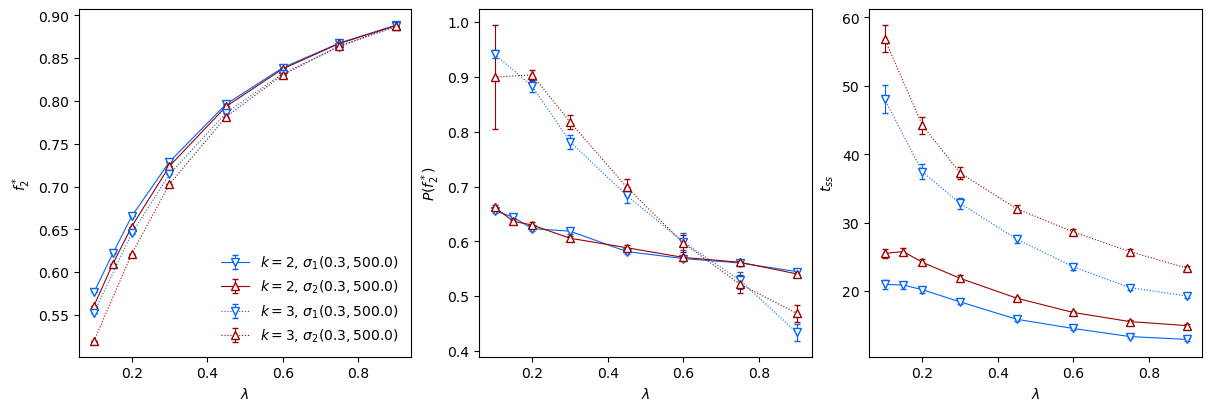

In [26]:
fig, ax = plt.subplots(1,3, figsize=(12,4), constrained_layout=True)
x = 1

ax[0].set(xlabel=r'$\lambda$', ylabel=r'$f_2^*$')
ax[1].set(xlabel=r'$\lambda$', ylabel=r'$P(f_2^*)$')
ax[2].set(xlabel=r'$\lambda$', ylabel=r'$t_{ss}$')

# species = []
# for ci_kwargs in ci_kwargs_list:
#     if len(ci_kwargs) == 1:
#         species.append("linear")
#     else:
#         species.append(fr"$\sigma_{ci_kwargs[0]} ({ci_kwargs[1]}, {ci_kwargs[2]})$")


ebars = True
# jitterer = np.linspace(-0.0,0.0, len(ci_kwargs_list))

# ci_kwargs_list = [(0, ), (1, 0.5, 10.0), (2, 0.3, 10.0), (1, 0.3, 500.0), (2, 0.3, 500.0)]
# color_seq = ['k', 'xkcd:sky blue', 'xkcd:light red', 'xkcd:bright blue', 'xkcd:deep red']
# marker_seq = ['o', 's', 'd', 'v', '^']

ci_kwargs_list = [(1, 0.3, 500.0), (2, 0.3, 500.0)]
# ci_kwargs_list = [(1, 0.3, 500.0), ]
color_seq = ['xkcd:bright blue', 'xkcd:deep red']
# color_seq = ['xkcd:bright blue', ]
marker_seq = ['v', '^']
# marker_seq = ['v', ]

for k, klinest in zip([2, 3], ['-', ':']):
    if k == 2:
        cfdata, ls, sitelb = cfdata2, ls2, 2
    elif k == 3:
        cfdata, ls, sitelb = cfdata3, ls3, 'k'
    print(klinest)
    for ci_kwargs, c, m in zip(ci_kwargs_list, color_seq, marker_seq):
        # if (k == 2 and ci_kwargs[0] > 0):
        #     cilabel = fr"$\sigma_{ci_kwargs[0]} ({ci_kwargs[1]}, {ci_kwargs[2]})$"
        # elif k==2 and ci_kwargs[0]:
        #     cilabel = 'linear'
        # else:
        #     cilabel = '_nolabel_'
        cilabel = fr"$k={k}$, $\sigma_{ci_kwargs[0]} ({ci_kwargs[1]}, {ci_kwargs[2]})$" if ci_kwargs[0] > 0 else fr"$k={k}$, linear"
        ax[0].errorbar(ls, cfdata[tuple(ci_kwargs)][f'f{sitelb}winVal'], cfdata[tuple(ci_kwargs)][f'f{sitelb}winValerr'], lw=0.8, ls=klinest, marker=m, color=c, mfc='w', label=cilabel, capsize=2.0)
        ax[1].errorbar(ls, cfdata[tuple(ci_kwargs)][f'probf{sitelb}winVal'], cfdata[tuple(ci_kwargs)][f'probf{sitelb}winValerr'], lw=0.8, ls=klinest, marker=m, color=c, mfc='w', capsize=2.0)
        ax[2].errorbar(ls, cfdata[tuple(ci_kwargs)]['tss'], cfdata[tuple(ci_kwargs)]['tsserr'], lw=0.8, ls=klinest, marker=m, color=c, mfc='w', capsize=2.0)

ax[0].legend(frameon=False)